# Example: Static inverse free-boundary equilibrium calculations

---

This example notebook shows how to use FreeGSNKE to solve **static inverse** free-boundary Grad-Shafranov (GS) problems. 

In the **inverse** solve mode we seek to estimate the active poloidal field coil currents using user-defined constraints (e.g. on isoflux, x-point, and psi values) and plasma current density profiles for a desired equilibrium shape. 

Note that during this solve, currents are **not** found in any specified passive structures. 

Below, we illustrate how to use the solver for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files partially come from the FreeGS repository and are not an exact replica of MAST-U.

### The static free-boundary Grad-Shafranov problem

Here we will outline the **static free-boundary** GS problem that is solved within both the **forward** and **inverse** solvers, though we encourage you to see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for more details. 

Using a cylindrical coordinate system $(R,\phi,Z)$, the aim is to solve the GS equation:

$$ \Delta^* \psi \equiv \left( \frac{\partial^2}{\partial R^2} - \frac{1}{R} \frac{\partial}{\partial R} + \frac{\partial^2}{\partial Z^2} \right) \psi = -\mu_0 R J_{\phi}(\psi, R, Z), \qquad (R,Z) \in \Omega, $$

for the poloidal flux $\psi(R,Z)$ (which here has units Weber/$2\pi$) in the rectangular computational domain $\Omega$. The flux has contributions from both the plasma and the coils (metals) such that $\psi = \psi_p + \psi_c$. This flux defines the toridal current density $J_{\psi} = J_p(\psi,R,Z) + J_c(R,Z)$, also containing a contribution from both the plasma and coils, respectively. We have the plasma current density (only valid in the core plasma region $\Omega_p$):

$$ J_p(\psi,R,Z) = R \frac{\mathrm{d}p}{\mathrm{d}\psi} +\frac{1}{\mu_0 R} F \frac{\mathrm{d} F}{\mathrm{d} \psi}, \qquad (R,Z) \in \Omega_p, $$

where $p(\psi)$ is the plasma pressure profile and $F(\psi)$ is the toroidal magnetic field profile. The current density generated by the ($N$) active coils and passive structures is given by:

$$ J_c(R,Z) = \sum_{j=1}^{N} \frac{I^c_j(R,Z)}{A_j^c}, \qquad (R,Z) \in \Omega, \quad \text{where} \quad I_j^c(R,Z) = 
\begin{cases} 
    I_j^c & \text{if } (R,Z) \in \Omega_j^c, \\ 
    0 & \text{elsewhere}.
\end{cases}.$$

This makes use of the current $I^c_j$ in each metal and its cross-sectional area $A^c_j$ (the domain of each metal is denoted by $\Omega_j^c$).

To complete the problem, we need the integral (Dirichlet) free-boundary condition:

$$ \psi(R,Z) = \int_{\Omega} G(R,Z;R',Z') J_{\phi}(\psi, R',Z') \ \mathrm{d}R' \mathrm{d}Z', \qquad (R,Z) \in \partial \Omega, $$

where $G$ is the (known) Green's function for the elliptic operator above.

### Import packages
We'll now go through the steps required to solve the **inverse** problem in FreeGSNKE. 

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

First, we build the machine object. This is done using the pickle files saved in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following environment variables in order to build the machine:
- `ACTIVE_COILS_PATH`
- `PASSIVE_COILS_PATH`
- `WALL_PATH`
- `LIMITER_PATH`
- `PROBE_PATH` (not required here).

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No probe configuration is provided


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

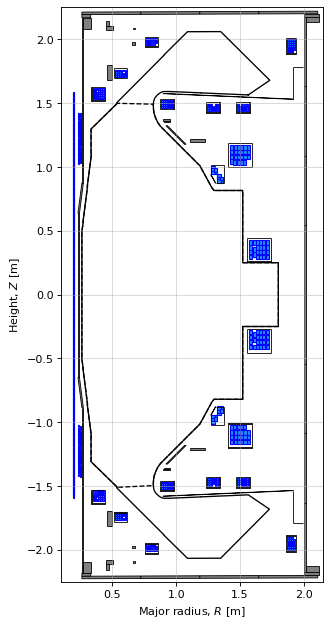

In [4]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

We are now ready to build a plasma equilibrium object for our tokamak. This is done using the `freegs4e.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters. The grid will be initialised using fourth-order finite differences. 

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux array (dimensions `nx` x `ny`) can be provided via the `psi` parameter (commented out in the following code). This can be used as an initial guess for the plasma flux $\psi_p$, noting that the total flux is given by $\psi(R,Z) = \psi_p(R,Z) + \psi_c(R,Z)$ where $\psi_c$ is the flux produced by currents in the active coils and passive structures. 

The `eq` object will store a lot of important information and derived quantites once the equilibrium has been calculated (see future notebook on this). 

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

We can now instatiate a profile object that contains the chosen parameterisation of the toroidal plasma current density $J_p$ (i.e. on right hand side of the GS equation). We can then set the paramters for the chosen current density profiles. 

A number of commonly used profile parameterisations exist in FreeGSNKE, including:
- `ConstrainPaxisIp`
- `ConstrainBetapIp`
- `Fiesta_Topeol`
- `Lao85`
- `ProfilesPprimeFfprime`
- `TensionSpline`

In this notebook, we will make use of the `ConstrainPaxisIp` (and `ConstrainBetapIp`) profiles (see [Jeon (2015)](https://link.springer.com/article/10.3938/jkps.67.843)). Others will be utilised in later notebooks. If there is a profile parameterisation you require that does not exist, please do create an issue. 

Both `ConstrainPaxisIp` and `ConstrainBetapIp` are parameterised as follows:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \beta_{0} \frac{R}{R_{0}} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} + (1-\beta_{0}) \frac{R_0}{R} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \big] \quad (R,Z) \in \Omega_p,$$

where the first term is the pressure profile and the second is the toroidal current profile. Here, $\tilde{\psi}$ denotes the normalised flux:
$$ \tilde{\psi} = \frac{\psi - \psi_a}{\psi_b - \psi_a}, $$
where $\psi_a$ and $\psi_b$ are the values of the flux on the magnetic axis and plasma boundary, respectively. 

The parameters required to define the object are:
- `Ip` (total plasma current).
- `fvac` ($rB_{tor}$, vacuum toroidal field strength).
- `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
- If `ConstrainPaxisIp` is used, then `paxis` (pressure on the magnetic axis) is required.
- If `ConstrainBetapIp` is used, then `betap` (proxy of the poloidal beta) is required.


The values of $\lambda$ and $\beta_0$ are found using the above parameters as constraints ($R_0$ is a fixed scaling constant) in the following:

- For `ConstrainPaxisIp`, we can re-arrange the following equations to solve for the unknowns:

$$ p_{\text{axis}} = \lambda \beta_{0} \frac{R}{R_{0}} \int^{\psi_b}_{\psi_a} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \mathrm{d} \tilde{\psi} $$

and

$$ I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


- For `ConstrainBetapIp`, we can instead re-arrange and solve the following:

$$ \beta_p = \frac{8 \pi}{\mu_0 I_p^2} \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} p(\psi) \ \mathrm{d}R \mathrm{d}Z. $$

and

$$I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


In what follows, we use `ConstrainPaxisIp`. Note that the equilibrium (`eq`) object is passed to the profile to inform calculations relating to the machine description.

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties. The solver below can be used for **both** inverse and forward solves. 

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid, and tokamak are consistent across solves. 

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

Recall that in the **inverse** solve mode we seek to **estimate the active poloidal field coil currents** using user-defined **constraints** (e.g. on isoflux, null points (x-point/o-points), and psi values) and plasma current density profiles for a desired equilibrium shape. 

FreeGSNKE uses a `constrain` object, which accepts constraints on:
- the location of any null points, which are either X-points or O-points (`null_points`).
- the locations of many pairs of points that lie on the same flux surface (`isoflux_set`). The flux at this pair of locations will be constrained to be the same. 
- the location of any known flux points (`psi_vals`), i.e. one can specify $\psi$ at any location $(R,Z)$, possibly an entire flux map (not used here). 

At least one constraint (preferably many more) is required to carry out an inverse solve.

Here, we specify two X-point locations (we want a double null plasma) and a number of isoflux locations. The isofluxes here will define the core plasma shape and part of the divertor legs. 

In [8]:
Rx = 0.6      # X-point radius
Zx = 1.1      # X-point height
Ra = .85
Rout = 1.4    # outboard midplane radius
Rin = 0.35    # inboard midplane radius

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx, Rx], [Zx, -Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, Rx, Rin, Rout, 1.3, 1.3, .8,.8], [Zx, -Zx, 0.,0., 2.1, -2.1,1.62,-1.62]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

Given that there may be more or less constraints than unknown parameters (i.e. coil currents), the inverse problem may be over- or under-constrained. This means that there may be zero, one, or many solutions to the problem. 

A number of quadratic (i.e.Tikhonov) regularization parameters will is used to combat this. Larger values will encourage lower absolute coil current values. It is sometimes useful to experiment with different values to explore whether the converged solution departs from the desired constraints. 


### The linear system of constraints

During an inverse solve, a minmisation problem involving the responses, changes in coil currents, and constraints, is repeatedly solved:

$$ \min_{x} \| A\vec{x} - \vec{b}\|^2 + \| \gamma \vec{x} \|^2, $$

where
- $A$: the fixed response matrix (that determines how a change in coil currents $x$, affects constraint values). 
- $\vec{x} = \Delta \vec{I}^c$: the step change in the active coil currents required to match the constraints. 
- $\vec{b}$: the vector of constraint values that we need. 
- $\gamma > 0$: the regularisation parameter.


--

The solution to this problem can be found by solving the linear system:

$$ (A^T A + \gamma^2 I)\vec{x} = A^T \vec{b}, $$

noting here that $I$ denotes the identity matrix, not the currents. 

[Song et al. (2024)](https://www.mdpi.com/2571-6182/7/4/45) provide a nice overview of the inverse problem.


### Fixed coil currents

It is also possible to set values for the current in specific active poloidal field coils. The inverse solver will not allow the current in these coils to vary if the `control` parameter is set to `False` (i.e. it will be excluded during the optimisation). 

Note: any passive structures in the tokamak automatically have their control parameter set to False and are therefore not included in an inverse solve. 

As an example, we will fix the `Solenoid` current and seek a solution in which this value is fixed, rather than estimated by the inverse solve.

In [9]:
eq.tokamak.set_coil_current('Solenoid', 5000)
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

### The inverse solve

The following cell will execute the solve. Since a `constrain` object is provided, this is interpreted as a call to the inverse solver, if `constrain=None`, then the forward solver will be called (see next notebook). The `target_relative_tolerance` is the maximum relative error on the plasma flux function allowed for convergence and `target_relative_psit_update` ensures that the relative update to psi_tokamak caused by the update in the control currents is lower than this target value for the inverse problem to be considered successfully solved.

The `verbose=True` will provide an indication of the progression of the solve. 

The solver needs stabilisation on any up-down antisymmetric coils. This can be set with `l2_reg` parameter: the Tikonov regularisation used by the optmiser of the coil currents. Here, `P6` is the last coil in the list of those available for control, and we're using a larger regularisation for it specifically. This is the length of the coils being controlled (so it excludes `Solenoid`). 

The solver steps are (roughly):
1. Solve the linear system to find initial coil currents that approximately satisfy the constraints for the initial equilibrium. 
2. While tolerance is not met:
 - use the coil currents to solve the forward GS problem (with NK iterations).
 - solve the linear system to update coil currents to satisfy constraints for current equilibrium (from forward solve). 
 - check tolerances. 

In [10]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

AttributeError: 'Machine' object has no attribute 'createBrGreensVec'

The following plots show how to display:
1. the tokamak with:
   - active coil filaments (rectangles with blue interior)
   - passive structures (blue circles if defined as filaments or thin black outline/grey interior if defined as parallelograms)
   - limiter/wall (solid black)
2. the tokamak + the equilibrium with:
   - separatrix/last closed flux surface (solid red lines)
   - poloidal flux (yellow/green/blue contours, colours indicates magnitude)
   - X-points (red circles)
   - O-points (green crosses)
3. the tokamak + the equilibrum + the contraints with:
   - X-point constraints (blue crosses)
   - isoflux contour constraints (blue triangles, with dashed blue lines)

Note: Setting 'show=True' can toggle the legend on/off.

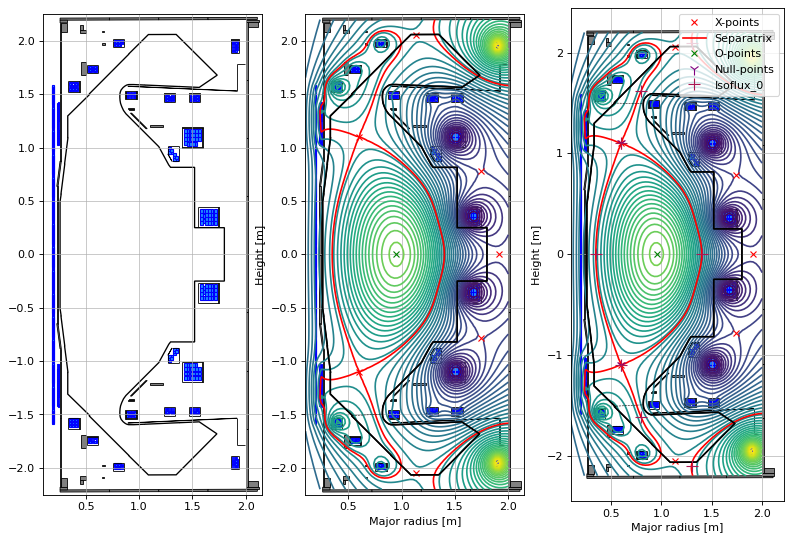

<Figure size 640x480 with 0 Axes>

In [ ]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=True)                                                          # plots the contraints
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various different quantities and functions can be accessed via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.
- (Total flux = plasma flux + coil flux)

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found with `profiles.jtor`).

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` having been assigned to the equilibrium object during the inverse solve.

The following lines will save the calculated currents to a pickle file (we will use these in future notebooks). 

In [ ]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### Second inverse solve: limited plasma example

Below we carry out an inverse solve seeking coil current values for a limited plasma configuration (rather than a diverted one). 

In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The last closed flux surface (LCFS) is the closed contour that is furthest from the magnetic axis that just barely touches (and is tangent to) the limiter.

We instantiate a new equilibrium but use the same profile object, and illustrate how to vary the total plasma current and pressure on axis within it. 

In [ ]:
# reset the coil currents and equilibrium
tokamak = build_machine.tokamak()
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

# first we specify some alterantive constraints
Rout = 1.4   # outboard midplane radius
Rin = 0.24   # inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
null_points = [[Rx, Rx], [Zx, -Zx]]


# isoflux constraints
isoflux_set = [[Rx, Rx, Rout, Rin, Rin, Rin, Rin, Rin, .75, .75, .85, .85, 1.3, 1.3],
           [Zx, -Zx,  0,  0,  .1, -.1, .2, -.2, 1.6, -1.6, 1.7, -1.7, 2.1, -2.1]]


# let's seek an up-down symmetric equilibrium by imposing the current in P6 is zero
#eq.tokamak.set_coil_current('P6', 0)
#eq.tokamak['P6'].control = False # fixes the current

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak.set_coil_current('Solenoid', 0)
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=False, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

No probe configuration is provided


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:650: RuntimeWarning: divide by zero encountered in scalar divide
  rel_delta_psit /= np.linalg.norm(self.tokamak_psi)
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:973: RuntimeWarning: invalid value encountered in scalar multiply
  previous_rel_delta_psit = rel_delta_psit * adj_factor
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.4742411369620173e-06 with less than 1 iterations. Last relative psi change: 0.9709762990248139.
  warnings.warn(
/Users/zn8047/Documents/freegs4e/freegs4e/jtor.py:548: RuntimeWarning: divide by zero encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)
/Users/zn8047/Documents/freegs4e/freegs4e/jtor.py:548: RuntimeWarning: invalid value encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)
/Users/zn8047/Documents/freegsnke/freegsnke/GSstatic

The initial coil currents and initial plasma_psi are significantly mismatched!
Please ensure that sufficient isoflux constraints are provided (for example 3 non-aligned points on the LCFS)
Initial setup of the currents triggered. Relative update of tokamak_psi in the core of: inf
Current updates: [ 1.16412545e+04  6.73442014e+03  3.11038751e+04  3.42713657e+04
 -1.88101467e+04  3.22545843e+04 -2.69820966e+04 -1.34542010e+04
 -4.79285515e+04  1.11157860e+04  1.19877596e-10]
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: nan
Current updates: [-0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0.]
Magnetic constraint losses = 0.007092690351003304
Handing off to forward_solve. Requested tolerance: nan
Forward static solve complete. Last relative residual: 0.9778181905547678
 
Iteration 1 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.00024742411369620175
Current updates: [-8.95899570e+01 -3.

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.48470941601501e-05 with less than 1 iterations. Last relative psi change: 0.8738335277544601.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.5311009328152e-05 with less than 1 iterations. Last relative psi change: 0.8544109875800973.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.598979479031171e-05 with less than 1 iterations. Last relative psi change: 0.8302555868737659.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.585052543919037e-05 with less than 1 iterations. Last relative psi 

Iteration 10 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0097966513992228
Current updates: [-4.21604540e+02 -2.78108826e+02 -1.39050945e+03 -1.51431202e+03
  8.40335991e+02 -1.43983591e+03  1.22239606e+03  6.09286840e+02
  2.14416681e+03 -6.26053506e+02 -1.29032382e-14]
Magnetic constraint losses = 0.055938511947085184
Handing off to forward_solve. Requested tolerance: 6.5311009328152e-05
Iteration 11 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.009898469218546757
Current updates: [-3.85840504e+02 -2.52014932e+02 -1.26133378e+03 -1.37265176e+03
  7.61792423e+02 -1.30538184e+03  1.10858535e+03  5.52313128e+02
  1.94311394e+03 -5.73940484e+02 -9.19803067e-15]
Magnetic constraint losses = 0.051538461899575984
Handing off to forward_solve. Requested tolerance: 6.598979479031171e-05
Discarding 'primary' Xpoint! Please check final result
Iteration 12 complete.
Using 

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.516363276774933e-05 with less than 1 iterations. Last relative psi change: 0.5932251153028092.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.345906266668262e-05 with less than 1 iterations. Last relative psi change: 0.5431804459666948.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 6.13952382828951e-05 with less than 1 iterations. Last relative psi change: 0.4881338737106656.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.833064496521859e-05 with less than 1 iterations. Last relative ps

Iteration 19 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.009518859400002393
Current updates: [-2.08191853e+02 -1.12319379e+02 -5.80305511e+02 -6.22974286e+02
  3.46305415e+02 -5.97761119e+02  5.07435566e+02  2.50467859e+02
  8.80144510e+02 -3.01606775e+02 -2.98245398e-15]
Magnetic constraint losses = 0.026467145521580974
Handing off to forward_solve. Requested tolerance: 6.345906266668262e-05
Iteration 20 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.009209285742434264
Current updates: [-1.95924257e+02 -1.00995199e+02 -5.26045707e+02 -5.62774716e+02
  3.13008080e+02 -5.41536709e+02  4.59328674e+02  2.26137357e+02
  7.94804913e+02 -2.80834568e+02 -5.80434188e-15]
Magnetic constraint losses = 0.024282606311631816
Handing off to forward_solve. Requested tolerance: 6.13952382828951e-05
Iteration 21 complete.
Using Greens' Jacobian
Control currents updated. Relative 

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 4.305342422422609e-06 with less than 5 iterations. Last relative psi change: 5.253991956859599e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 2.3664569739811274e-06
 
Iteration 40 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.005483923507966887
Current updates: [-4.15962645e+01  9.68906350e+00  1.68475837e+01  3.12941421e+01
 -1.64477697e+01  1.75727917e+01 -1.89006483e+01 -1.32215683e+01
 -4.36712927e+01 -3.43314057e+01 -2.46659222e-06]
Magnetic constraint losses = 0.008394221280466142
Handing off to forward_solve. Requested tolerance: 3.2096122954721607e-06
Iteration 41 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.004240744837173088
Current updates: [ 3.36194807e+01 -7.89292602e+00 -1.27432316e+01 -2.51997862e+01
  1.23283595e+01 -1.49347488e+01  1.52850457e+01  1.09290403e+01
  3.71399193e+01  2.81284590e+01 -9.05507207e-06]
Magnetic constraint losses = 0.00709308471802191
Handing off to forward_solve. Requested tolerance: 2.4820088667496812e-06

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.2096122954721607e-06 with less than 5 iterations. Last relative psi change: 6.333638423902676e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 2.2368462780941476e-06
 
Iteration 42 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0035464961679041547
Current updates: [-2.69607429e+01  6.18833105e+00  1.07867223e+01  1.99047499e+01
 -1.06135472e+01  1.11765243e+01 -1.19440086e+01 -8.34409683e+00
 -2.76091021e+01 -2.30910493e+01 -2.09857595e-06]
Magnetic constraint losses = 0.005782147063248323
Handing off to forward_solve. Requested tolerance: 2.0756813419832272e-06
Forward static solve complete. Last relative residual: 1.926544624208154e-06
 
Iteration 43 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0026152414511108374
Current updates: [ 2.03161246e+01 -4.69417423e+00 -7.25700722e+00 -1.48847375e+01
  7.09578217e+00 -8.98936410e+00  8.98639072e+00  6.51146933e+00
  2.24251796e+01  1.75245917e+01 -5.72264039e-07]
Magnetic constraint losses = 0.0045928507

In [ ]:
# save the currents for later use
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

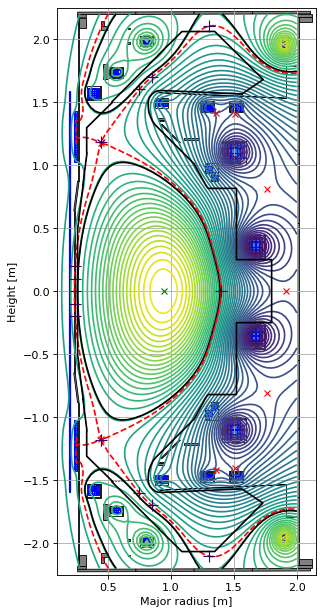

In [ ]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=True)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

Now, let's assume we wish to set the solenoid current to 40000 Amperes. We can do so starting from the equilibrium we just built and adding a 'curr_vals' constraint to the constrain object.
This will add a term to the loss connected to the value of the Solenoid current

In [ ]:
# curr_vals constraints are of the form
# [coil indexes in the array of coils available for control, coil current values]
# in this case we're controlling the Solenoid:
curr_vals = [[0], [40000.]]

# add the constraints to a new freegsnke Inverse_optimizer object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set,
                              curr_vals=curr_vals)

# remember to switch ON the control of the Solenoid, which was previously OFF!
eq.tokamak['Solenoid'].control = True

Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.03962372e+02  7.89662362e+00  2.67363319e+01  2.33663670e+01
  2.95129629e+01  3.41102443e+01  3.78482477e+01  2.72246759e+01
  2.56695729e+01  1.06634274e+01 -1.25873531e+01 -2.57119105e-05]
Magnetic constraint losses = 69282.03327749077
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 1 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 6.80099172e+02  7.77822523e+00  2.60429544e+01  2.26633243e+01
  2.86067567e+01  3.29421631e+01  3.67041271e+01  2.62980014e+01
  2.48175019e+01  1.02161621e+01 -1.22702531e+01  1.03320080e-07]
Magnetic constraint losses = 68062.73553208528
Handing off to forward_solve. Requested tolerance: 0.0002
Forward static solve complete. Last relative residual: 4.458077669781464e-05
 
Iteration 2 complete.
Using Greens' Jacobian
Control currents

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 1 iterations. Last relative psi change: 0.0003169233597812158.
  warnings.warn(


Forward static solve complete. Last relative residual: 5.9501446754338844e-05
 
Iteration 5 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 5.92343768e+02  7.27450967e+00  2.34084224e+01  2.00484025e+01
  2.52496455e+01  2.86654238e+01  3.24470771e+01  2.28947382e+01
  2.16713272e+01  8.57347624e+00 -1.12141548e+01  9.56751023e-08]
Magnetic constraint losses = 63586.71292982629
Handing off to forward_solve. Requested tolerance: 0.0002
Forward static solve complete. Last relative residual: 6.042414274944959e-05
 
Iteration 6 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 5.76063023e+02  7.19802567e+00  2.29391452e+01  1.95693351e+01
  2.46330748e+01  2.78634262e+01  3.16687703e+01  2.22585931e+01
  2.10868350e+01  8.25988169e+00 -1.10139441e+01  9.44188148e-08]
Magnetic constraint losses = 62560.744833973375
Handing off to f

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0037449334917338617.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0021668552143259026.
  warnings.warn(


Iteration 48 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.08289590e+02  2.17933148e+01  4.45909664e+01  3.00225640e+01
  3.67114015e+01  2.98649034e+01  4.91843983e+01  2.48440058e+01
  2.58517858e+01  2.00244827e+00 -1.93287094e+01  2.60609116e-07]
Magnetic constraint losses = 25502.389114185946
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 49 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.38179266e+02  2.34054813e+01  4.78723782e+01  3.19206720e+01
  3.89014022e+01  3.13007605e+01  5.20918770e+01  2.59562814e+01
  2.70362303e+01  1.38573445e+00 -2.20714348e+01  2.83960794e-07]
Magnetic constraint losses = 24275.59672475849
Handing off to forward_solve. Requested tolerance: 0.0002


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.11378122172510104.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 1 iterations. Last relative psi change: 0.026168913414235728.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0033039665420752876.
  warnings.warn(


Iteration 50 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 7.83633498e+02  2.85703826e+01  5.11782636e+01  3.27181007e+01
  4.06624877e+01  2.73591600e+01  5.58321313e+01  2.41917400e+01
  2.69074650e+01 -6.86089817e-01 -1.66127112e+01  3.16530288e-07]
Magnetic constraint losses = 22997.036248784916
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 51 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 8.25601586e+02  2.94082318e+01  5.65621588e+01  3.63441120e+01
  4.45605729e+01  3.19960712e+01  6.00375185e+01  2.69907317e+01
  2.89916788e+01 -2.03449176e+00 -2.79368203e+01  3.52308377e-07]
Magnetic constraint losses = 21639.74404611463
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 52 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core 

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0018714259456672098.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.001268164711994977.
  warnings.warn(


Iteration 53 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 8.52046168e+02  3.34194749e+01  6.50213326e+01  4.05961832e+01
  4.81311256e+01  3.54275783e+01  6.55654856e+01  2.98073558e+01
  3.22525846e+01 -4.57502260e-01 -2.36100235e+01  4.13058365e-07]
Magnetic constraint losses = 18789.58348285878
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 54 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 8.93645537e+02  3.72341672e+01  7.18499708e+01  4.40157773e+01
  5.18445335e+01  3.69270415e+01  7.07602701e+01  3.10538840e+01
  3.39106388e+01 -2.12746512e+00 -2.74501256e+01  4.66461268e-07]
Magnetic constraint losses = 17313.79707560207
Handing off to forward_solve. Requested tolerance: 0.0002


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0026118320027819384.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0008404055690516663.
  warnings.warn(


Iteration 55 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 9.32449432e+02  4.20002887e+01  7.96661969e+01  4.76005024e+01
  5.55304666e+01  3.77711662e+01  7.63452544e+01  3.20172094e+01
  3.56184695e+01 -3.60920016e+00 -2.83649763e+01  5.29723730e-07]
Magnetic constraint losses = 15765.957991304045
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 56 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 9.79614568e+02  4.79600002e+01  8.99089542e+01  5.23212823e+01
  6.04063747e+01  3.89817446e+01  8.35053111e+01  3.31895653e+01
  3.76216914e+01 -6.11420238e+00 -3.19416058e+01  6.13685388e-07]
Magnetic constraint losses = 14150.908703668283
Handing off to forward_solve. Requested tolerance: 0.0002


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.002675507480488816.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.020104662241397262.
  warnings.warn(


Iteration 57 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.01374654e+03  5.46286587e+01  1.01825294e+02  5.75592696e+01
  6.52372770e+01  4.03808253e+01  9.09434677e+01  3.45149279e+01
  3.99245940e+01 -8.02521573e+00 -3.28848149e+01  7.12940942e-07]
Magnetic constraint losses = 12454.166292832062
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 58 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.05632872e+03  6.32386753e+01  1.18438798e+02  6.49058764e+01
  7.18777644e+01  4.28228338e+01  1.00885785e+02  3.64423091e+01
  4.29293094e+01 -1.10901915e+01 -3.71193364e+01  8.52627922e-07]
Magnetic constraint losses = 10698.305318462828
Handing off to forward_solve. Requested tolerance: 0.0002


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0008336256399574624.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.002773356765152334.
  warnings.warn(


Iteration 59 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.13839379e+03  8.10952529e+01  1.43982722e+02  7.42145548e+01
  8.13431925e+01  3.74008091e+01  1.16752230e+02  3.37717188e+01
  4.39677449e+01 -2.12281899e+01 -4.12100600e+01  1.08948390e-06]
Magnetic constraint losses = 8868.690844880715
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 60 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.17383387e+03  1.03215371e+02  1.78428911e+02  8.61851063e+01
  9.12600139e+01  3.13455114e+01  1.34749640e+02  3.07470736e+01
  4.56831235e+01 -3.06406649e+01 -3.54542712e+01  1.41246960e-06]
Magnetic constraint losses = 6896.934215479377
Handing off to forward_solve. Requested tolerance: 0.0002


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.0014587202804467517.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0002 with less than 5 iterations. Last relative psi change: 0.00027998727161308845.
  warnings.warn(


Iteration 61 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.25139383e+03  1.44611708e+02  2.48028420e+02  1.11064631e+02
  1.12445893e+02  2.15171350e+01  1.70730246e+02  2.50908984e+01
  4.81917948e+01 -5.35411188e+01 -4.42012218e+01  2.07233366e-06]
Magnetic constraint losses = 4863.792902129205
Handing off to forward_solve. Requested tolerance: 0.0002
Iteration 62 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.02
Current updates: [ 1.27188652e+03  2.41706503e+02  4.02860745e+02  1.58272111e+02
  1.47331636e+02 -2.34456600e+01  2.40879914e+02 -2.21132790e+00
  4.42693564e+01 -1.05858176e+02 -1.78819929e+01  3.63022331e-06]
Magnetic constraint losses = 2696.3130199694447
Handing off to forward_solve. Requested tolerance: 0.0002
Forward static solve complete. Last relative residual: 0.00017685190648245613
 
Iteration 63 complete.
Using Greens

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.360455220598333e-05 with less than 5 iterations. Last relative psi change: 4.479183230545869e-05.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.9524877741383625e-05 with less than 5 iterations. Last relative psi change: 0.0015994195225618067.
  warnings.warn(


Iteration 64 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0029524877741383625
Current updates: [ 3.05039779e-07  1.86135262e+02  3.28706705e+02  8.70471407e+01
  5.52619470e+01 -1.33885820e+02  1.30112277e+02 -8.41521300e+01
 -2.66247339e+01 -1.17803728e+02  1.23250487e+02  3.59895940e-06]
Magnetic constraint losses = 0.050311559881224294
Handing off to forward_solve. Requested tolerance: 2.9524877741383625e-05
Iteration 65 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.007396843028596436
Current updates: [ 1.59830242e-08  1.26367486e+02  2.75134340e+02  7.57450484e+01
  5.87672307e+01 -1.18139134e+02  1.03417951e+02 -8.64668189e+01
 -4.51793038e+01 -1.54851458e+02 -6.97073398e+01  3.18149603e-06]
Magnetic constraint losses = 0.04573528593959965
Handing off to forward_solve. Requested tolerance: 7.396843028596436e-05


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 7.396843028596436e-05 with less than 5 iterations. Last relative psi change: 0.0012256511014886342.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 0.0001043725604954814 with less than 5 iterations. Last relative psi change: 0.0029874289026744277.
  warnings.warn(


Iteration 66 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.01565588407432221
Current updates: [ 1.41736493e-08  1.29929494e+02  2.44493524e+02  5.53399259e+01
  2.52268020e+01 -1.31751012e+02  9.83077478e+01 -6.81626099e+01
 -4.91719191e+00 -2.52733552e+01  4.17186950e+02  2.81856384e-06]
Magnetic constraint losses = 0.05704029661679074
Handing off to forward_solve. Requested tolerance: 0.0001043725604954814
Iteration 67 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.018447363199999997
Current updates: [-3.78918800e-09 -5.28567432e+00  6.49377129e+01  3.00395450e+01
  3.78712957e+01 -2.57619846e+00  2.30924950e+01 -2.02058179e+01
 -2.73130792e+01 -9.92915056e+01 -2.89304003e+02  7.92101262e-07]
Magnetic constraint losses = 0.09644438518325586
Handing off to forward_solve. Requested tolerance: 8.198828088888888e-05


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 8.198828088888888e-05 with less than 5 iterations. Last relative psi change: 0.00020056722340737137.
  warnings.warn(


Iteration 68 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.007813278523270444
Current updates: [ 1.15896202e-08  8.31691700e+01  1.95758620e+02  4.66571371e+01
  3.13950625e+01 -1.15211874e+02  7.71408606e+01 -6.84523761e+01
 -2.00604264e+01 -5.89391917e+01  2.39090166e+02  2.38072283e-06]
Magnetic constraint losses = 0.044917870389370305
Handing off to forward_solve. Requested tolerance: 3.472568232564642e-05
Forward static solve complete. Last relative residual: 2.1567371436022854e-05
 
Iteration 69 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.017716847617279995
Current updates: [-2.52008855e-09  6.67258058e+00  1.26876552e+02  4.86367512e+01
  5.80238277e+01 -3.92136610e+01  4.82401786e+01 -4.70963055e+01
 -4.15338326e+01 -1.41322010e+02 -2.80301510e+02  1.60656027e-06]
Magnetic constraint losses = 0.0527425863986782
Handing off to forward_solve. Requested tol

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 5.249436331045925e-05 with less than 5 iterations. Last relative psi change: 0.00058816409847963.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.429631736283338e-05 with less than 5 iterations. Last relative psi change: 0.04220363413524172.
  warnings.warn(


Iteration 70 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.017362510664934397
Current updates: [ 9.42260969e-09  3.01703869e+01  1.26934983e+02  3.73246352e+01
  1.10331543e+01 -2.58920038e+01  5.26865711e+01  1.24722904e+00
  3.41076755e+01  6.58041977e+01  4.17548755e+02  1.41615219e-06]
Magnetic constraint losses = 0.06789336991851452
Handing off to forward_solve. Requested tolerance: 3.429631736283338e-05
Iteration 71 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.016918760565348856
Current updates: [ 7.04711692e-09  2.00777471e+01  1.19885308e+02  3.07861134e+01
  4.21289166e+01 -1.07003962e+02  2.87658911e+01 -9.34775943e+01
 -7.35414003e+01 -1.68710356e+02 -1.99939441e+02  1.78122398e-06]
Magnetic constraint losses = 0.04552499098108486
Handing off to forward_solve. Requested tolerance: 3.341977395624465e-05
Forward static solve complete. Last relative resid

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.9959415365193046e-05 with less than 5 iterations. Last relative psi change: 0.00020567213473620142.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.1519613020906584e-05 with less than 5 iterations. Last relative psi change: 8.004074591110765e-05.
  warnings.warn(


Iteration 74 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.015204558136609404
Current updates: [ 9.59333475e-09 -6.29020861e+00  1.11779704e+02  3.78391057e+01
  1.96358286e+01 -1.60683287e+01  4.76211160e+01  2.59081062e+00
  2.94336507e+01  5.07704752e+01  3.47844753e+02  1.33695118e-06]
Magnetic constraint losses = 0.04744750272436397
Handing off to forward_solve. Requested tolerance: 2.0022463389773702e-05
Iteration 75 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.015694334474696
Current updates: [-1.16832981e-10 -1.67116844e+01  2.95155285e+01  1.15657729e+01
  2.60464366e+01 -2.95246261e+01  8.57343750e+00 -3.49020143e+01
 -3.65665719e+01 -9.53151769e+01 -2.24086545e+02  5.40145377e-07]
Magnetic constraint losses = 0.06911834798460385
Handing off to forward_solve. Requested tolerance: 1.3778290896852455e-05


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.0022463389773702e-05 with less than 5 iterations. Last relative psi change: 0.01814056352664844.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.3778290896852455e-05 with less than 5 iterations. Last relative psi change: 1.9814599887168257e-05.
  warnings.warn(


Iteration 76 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.004253937300398276
Current updates: [ 3.47528265e-09 -1.77266406e+01  8.76107864e+01  3.06444871e+01
  2.80385261e+01 -2.93978949e+01  3.47752647e+01 -1.95882519e+01
 -2.35209867e+00 -2.06920763e+01  1.10385522e+02  1.13972118e-06]
Magnetic constraint losses = 0.028123625961089874
Handing off to forward_solve. Requested tolerance: 3.7345951608434797e-06
Iteration 77 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.008526895858188806
Current updates: [ 6.61842864e-10 -2.67002506e+01  7.05480551e+01  2.66529538e+01
  3.91495065e+01 -4.13093170e+01  2.67985213e+01 -4.01643972e+01
 -3.17222479e+01 -9.11046367e+01 -1.20989032e+02  1.03107193e-06]
Magnetic constraint losses = 0.03133148048955795
Handing off to forward_solve. Requested tolerance: 4.9905929119715006e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.7345951608434797e-06 with less than 5 iterations. Last relative psi change: 7.154006323163704e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 4.9905929119715006e-06 with less than 5 iterations. Last relative psi change: 1.197513491906142e-05.
  warnings.warn(


Iteration 78 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.010612584027000759
Current updates: [ 5.25547610e-09 -2.42122900e+01  7.38308136e+01  2.77714146e+01
  1.85292724e+01 -8.43104563e+00  3.14613562e+01  1.82423011e+00
  1.93975153e+01  3.22771651e+01  2.37502279e+02  9.34334048e-07]
Magnetic constraint losses = 0.036750079682221895
Handing off to forward_solve. Requested tolerance: 4.1408649762417225e-06
Iteration 79 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.014475954411849911
Current updates: [-1.34728944e-09 -2.47077652e+01  3.05470376e+01  1.35631055e+01
  3.08079009e+01 -3.06977672e+01  1.09693841e+01 -3.59483774e+01
 -3.67531816e+01 -9.77466986e+01 -2.17488036e+02  5.50090502e-07]
Magnetic constraint losses = 0.05260648035593708
Handing off to forward_solve. Requested tolerance: 3.7655279473998652e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 4.1408649762417225e-06 with less than 5 iterations. Last relative psi change: 3.1856487253479577e-05.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 3.7655279473998652e-06 with less than 5 iterations. Last relative psi change: 2.920545938590335e-05.
  warnings.warn(


Iteration 80 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.011004927724883904
Current updates: [ 5.25753321e-09 -2.59089163e+01  6.16885140e+01  2.33595467e+01
  1.42121582e+01 -5.78474513e+00  2.62009082e+01  4.39604613e+00
  2.08890744e+01  4.00502201e+01  2.48153414e+02  7.92089490e-07]
Magnetic constraint losses = 0.03797555205537537
Handing off to forward_solve. Requested tolerance: 2.8626342504397493e-06
Iteration 81 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.013902706617140654
Current updates: [-2.03906356e-09 -2.60325103e+01  2.47214719e+01  1.23267156e+01
  2.90614323e+01 -2.51233449e+01  8.67804494e+00 -3.18105463e+01
 -3.39975847e+01 -9.10550464e+01 -2.12859491e+02  4.58173295e-07]
Magnetic constraint losses = 0.053101480956295924
Handing off to forward_solve. Requested tolerance: 2.410942027121887e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.8626342504397493e-06 with less than 5 iterations. Last relative psi change: 0.00021547326883041297.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.410942027121887e-06 with less than 5 iterations. Last relative psi change: 2.5555942585147635e-05.
  warnings.warn(


Iteration 82 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.00951729222599031
Current updates: [ 4.68555854e-09 -2.69136071e+01  5.12987424e+01  1.96778697e+01
  1.29887983e+01 -6.66038927e+00  2.15270173e+01  2.28993017e+00
  1.67228181e+01  3.29615163e+01  2.15749432e+02  6.75590010e-07]
Magnetic constraint losses = 0.034657685014963635
Handing off to forward_solve. Requested tolerance: 1.6504440785473213e-06
Iteration 83 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.013352159435101884
Current updates: [-2.41086897e-09 -3.09477243e+01  2.68685329e+01  1.39998858e+01
  3.13021091e+01 -2.43525572e+01  9.46832485e+00 -3.17055514e+01
 -3.37514401e+01 -9.14887230e+01 -2.09093098e+02  4.79173112e-07]
Magnetic constraint losses = 0.045527761029373434
Handing off to forward_solve. Requested tolerance: 1.5436458152319068e-06
Iteration 84 complete.
Using Greens' Jacobian
C

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.6504440785473213e-06 with less than 5 iterations. Last relative psi change: 4.1443910580787106e-05.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.5436458152319068e-06 with less than 5 iterations. Last relative psi change: 2.0035204877495744e-05.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.2634242408722763e-06 with less than 5 iterations. Last relative psi change: 0.0005088986839732178.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi

Iteration 85 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.01282341392147185
Current updates: [-2.77214754e-09 -2.78424146e+01  1.86592502e+01  1.13176286e+01
  2.75803087e+01 -1.87097491e+01  6.63666891e+00 -2.68447040e+01
 -3.03178529e+01 -8.25052211e+01 -2.02545463e+02  3.55637329e-07]
Magnetic constraint losses = 0.05009113435982611
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 86 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.008181544733467504
Current updates: [ 4.08648977e-09 -2.55453887e+01  3.63156198e+01  1.43291919e+01
  1.01423862e+01 -6.38419912e+00  1.55100012e+01  1.52381315e+00
  1.35434999e+01  2.91591727e+01  1.87081945e+02  4.92272856e-07]
Magnetic constraint losses = 0.031967727073335804
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.2968941417830402e-05.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 0.00011561382309049762.
  warnings.warn(


Iteration 87 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.012315606730181564
Current updates: [-2.93313054e-09 -3.61448224e+01  2.54129924e+01  1.48718786e+01
  3.29665018e+01 -2.16221216e+01  9.30540620e+00 -2.98802516e+01
 -3.21295769e+01 -8.83413332e+01 -1.99114987e+02  4.46214151e-07]
Magnetic constraint losses = 0.03782457518387474
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 88 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.011001083273676177
Current updates: [ 5.35367488e-09 -2.16651084e+01  3.15590587e+01  1.20120091e+01
  4.44604967e+00 -2.20046068e+00  1.47444946e+01  8.52247288e+00
  2.23555500e+01  5.26999698e+01  2.54929655e+02  4.16170228e-07]
Magnetic constraint losses = 0.04177505872596373
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 0.0007873604440118296.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.6288206911311073e-05.
  warnings.warn(


Iteration 89 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.011827908703666372
Current updates: [-3.10586009e-09 -2.76121311e+01  1.36712917e+01  1.03448418e+01
  2.56500381e+01 -1.26214476e+01  4.97817457e+00 -2.19217745e+01
 -2.65280549e+01 -7.38102782e+01 -1.92052749e+02  2.65085417e-07]
Magnetic constraint losses = 0.048896228242088016
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 90 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.006783792283757668
Current updates: [ 3.52428593e-09 -2.26730101e+01  2.60144686e+01  1.06280902e+01
  8.51486245e+00 -6.70935082e+00  1.13446733e+01  1.79751088e-01
  1.02078135e+01  2.35390666e+01  1.56928531e+02  3.60224958e-07]
Magnetic constraint losses = 0.028895947248344545
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 9.961289492081469e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 6.22395965860263e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.0907621591820127e-05.
  warnings.warn(


Iteration 91 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.008866856330667094
Current updates: [-2.48650033e-09 -3.18654160e+01  1.94163854e+01  1.24352427e+01
  2.74317792e+01 -1.60716083e+01  7.53581347e+00 -2.27477313e+01
 -2.42284795e+01 -6.72687395e+01 -1.45427241e+02  3.32569360e-07]
Magnetic constraint losses = 0.030934533812860914
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 92 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.00745068282853564
Current updates: [ 3.64488309e-09 -2.04162188e+01  2.27508631e+01  9.59137293e+00
  6.83534131e+00 -4.39924158e+00  1.07291908e+01  2.80516363e+00
  1.28070881e+01  3.00874776e+01  1.70861259e+02  3.07415365e-07]
Magnetic constraint losses = 0.031442126135946484
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 93 complete.
Using Greens' Jacobian
Control currents updated. Relative 

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 6.497718893539418e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.0025898879329962e-05.
  warnings.warn(


Iteration 94 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.007173597412332187
Current updates: [ 3.57108588e-09 -1.87081188e+01  1.96651948e+01  8.52248462e+00
  6.07854927e+00 -3.86422416e+00  9.56354756e+00  3.02875360e+00
  1.24421867e+01  2.97664241e+01  1.64683662e+02  2.63614009e-07]
Magnetic constraint losses = 0.031220243867355633
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 95 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.008117850928053021
Current updates: [-2.49257723e-09 -2.84846220e+01  1.42678222e+01  1.08596193e+01
  2.50344446e+01 -1.21995864e+01  6.02009384e+00 -1.91630827e+01
 -2.13237288e+01 -5.99390676e+01 -1.35629002e+02  2.44537638e-07]
Magnetic constraint losses = 0.030132959898234814
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.4528726909037955e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 6.0795846361939536e-06.
  warnings.warn(


Iteration 96 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.006072679638979305
Current updates: [ 3.07662646e-09 -1.77310084e+01  1.68996773e+01  7.76419153e+00
  6.57496736e+00 -4.09270465e+00  8.29325598e+00  1.65719308e+00
  9.83751083e+00  2.35379813e+01  1.39753878e+02  2.27098130e-07]
Magnetic constraint losses = 0.02802754022844782
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 97 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.006269544733964474
Current updates: [-1.96533057e-09 -2.57882131e+01  1.27484577e+01  9.86040386e+00
  2.21108192e+01 -1.03226800e+01  5.57336179e+00 -1.60217988e+01
 -1.73553686e+01 -4.91563539e+01 -1.04860730e+02  2.11135105e-07]
Magnetic constraint losses = 0.025736295943281886
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 6.869352792539434e-06.
  warnings.warn(
/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.2788985137414876e-05.
  warnings.warn(


Iteration 98 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.004523665171480679
Current updates: [ 2.32666946e-09 -1.72851548e+01  1.44805202e+01  7.29704015e+00
  7.90906434e+00 -4.58440978e+00  7.13367992e+00 -4.87637077e-01
  6.08443549e+00  1.40186035e+01  1.04145611e+02  1.96506574e-07]
Magnetic constraint losses = 0.023041127206141487
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 99 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.004177116345524239
Current updates: [-1.28969064e-09 -2.29172803e+01  1.15713126e+01  8.85198830e+00
  1.88697648e+01 -8.54652275e+00  5.26741389e+00 -1.26490762e+01
 -1.28732889e+01 -3.69425400e+01 -6.85228644e+01  1.83085493e-07]
Magnetic constraint losses = 0.020462167907667982
Handing off to forward_solve. Requested tolerance: 1e-06


/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 4.258348448563278e-06.
  warnings.warn(


Iteration 100 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.002775830437428454
Current updates: [ 1.51332907e-09 -1.71749434e+01  1.23945265e+01  7.04294911e+00
  9.57213480e+00 -4.92207090e+00  6.20427971e+00 -2.64809594e+00
  2.21424954e+00  3.81200038e+00  6.59728937e+01  1.70757548e-07]
Magnetic constraint losses = 0.017866264562077246
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 5.220523421436016e-07
 
Iteration 101 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0023220367422017193
Current updates: [-6.37448524e-10 -2.02988069e+01  1.05385734e+01  7.92194204e+00
  1.59098438e+01 -6.96821725e+00  5.06502492e+00 -9.57929856e+00
 -8.78236775e+00 -2.58608502e+01 -3.56297035e+01  1.59421799e-07]
Magnetic constraint losses = 0.01608696400524533
Handing off to forward_solve. Requested tolerance: 1e-06

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 5 iterations. Last relative psi change: 1.6098662062848617e-06.
  warnings.warn(


Forward static solve complete. Last relative residual: 7.358474101155348e-07
 
Iteration 104 complete.
Using Greens' Jacobian
Control currents updated. Relative update of tokamak_psi in the core of: 0.0006707140643435345
Current updates: [ 5.52444910e-10 -1.60963054e+01  9.31642091e+00  6.41943208e+00
  1.09628207e+01 -4.95958516e+00  4.80302147e+00 -4.83968957e+00
 -2.10599230e+00 -7.44458287e+00  2.12659410e+01  1.30497223e-07]
Magnetic constraint losses = 0.013186072411641707
Handing off to forward_solve. Requested tolerance: 1e-06
Forward static solve complete. Last relative residual: 2.966645198583588e-07
 
Iteration 105 complete.
Static solve complete.
Last update to the control currents caused a relative update of tokamak_psi in the core of: 0.0006707140643435345.
Last relative GS residual: 2.966645198583588e-07


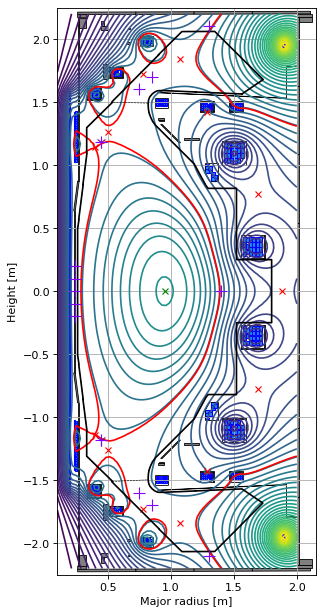

In [ ]:
# carry out the inverse solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     max_solving_iterations=150,
                     force_up_down_symmetric=True,
                     verbose=True,
                     )

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

In [ ]:
# finally, let's check the Solenoid current:
eq.tokamak['Solenoid'].current

39999.999999989996